In [ ]:
#匯入所需套件
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats 

### 只保留有數字的薪資，排除面議的

In [ ]:
df=pd.read_csv(r"C:\Users\FM_pc\Desktop\暫時匯出查看.csv")
df_filter=df[df['薪資是否為面議']==0].copy()    #只保留'非面議'的資料

In [ ]:
#增加新欄位「要求python」(有要求=1,無要求=0)
df_filter['要求python']=df_filter['專長工具'].fillna('').str.contains('python',case=False)

In [124]:
df_filter.tail(5)

,上架日期,申請人數,公司名稱,description,縣市,職稱,工作編號,經度,緯度,major,...,是否積極徵才,員工人數,搜尋關鍵字,薪資是否為面議,是否要求特定major,八大產業,公司規模,工作經驗,專長工具,要求python
562,20250711,11,佳世達科技股份有限公司,"1.資料結構分析, 包含收集、清理、分析和整合資料\n2.分析問題，提出建議並協助建立和驗證...",台北市,資料科學家【資訊技術服務處】(台北),13896904,25.068942,121.590903,"['資訊管理相關', '數理統計相關', '資訊工程相關']",...,0,30000.0,數據科學,0,1,製造業,大型,1年以上,NaN,False
569,20250625,14,世銳顧問有限公司,Xelay Acumen Data Science Analysts are a diver...,台北市,"Data Science Analyst (Taipei, Taiwan)",14362141,25.053372,121.522852,[],...,0,20.0,數據科學,0,0,服務與專業顧問業,小型,不拘,"Excel, PowerPoint",False
578,20250630,1,威果農業股份有限公司,用數據驅動農業革命，打造「農業自動駕駛」系統！\n我們正建立全球化的智慧農業決策系統，你需要...,台南市,智慧農業數據分析師,14603284,23.176340,120.239734,"['應用數學相關', '資訊工程相關']",...,0,7.0,數據科學,0,1,批發與零售業,小型,2年以上,Python,True
586,20250715,5,華權數位整合行銷有限公司,主要工作述敘：\n1. 數據分析與精算：\n■分析遊戲玩家行為數據、直播主表現數據，協助優化...,台中市,數據分析師,14424533,24.116516,120.615540,"['統計學相關', '數理統計相關', '應用數學相關']",...,0,NaN,數據分析,0,1,服務與專業顧問業,未知,1年以上,NaN,False
588,20250709,2,CONTIN 康定_奇來生技有限公司,團媽 合作效益追蹤機制，量化其曝光、導流與銷售成效，並提出合作優化建議。\n\n3.利用 G...,高雄市,數位行銷數據分析師,14620764,22.641587,120.385938,[],...,0,NaN,數據分析,0,0,製造業,未知,2年以上,"Line, Instagram, Facebook, Google Analytics, G...",False


### 分組薪資資料

In [ ]:
#將薪資資料分為兩組，'有要求python'與'無要求python'的薪資。
with_py=df_filter[df_filter['要求python']]['薪資下限']
without_py=df_filter[~df_filter['要求python']]['薪資下限']

### 要求python描述統計

In [126]:
with_py.describe()

count        89.000000
mean      53780.011236
std       20679.252841
min       28590.000000
25%       39000.000000
50%       45000.000000
75%       70000.000000
max      133333.000000
Name: 薪資下限, dtype: float64

### 不要求python描述統計

In [127]:
without_py.describe()

count        91.000000
mean      44094.879121
std       13682.795895
min       30000.000000
25%       35000.000000
50%       40000.000000
75%       48253.000000
max      100000.000000
Name: 薪資下限, dtype: float64

### 繪製箱型圖，判斷資料是否偏態、觀察極端值
<p>若是偏態太嚴重，則會違反T檢定的前提</p>
<p>T檢定的前提:</p>
<p>1.資料呈現常態分佈</p>
<p>2.變異數同質性</p>
<p>2.樣本之間互相獨立</p>

In [1]:
plt.figure(figsize=(12,5))
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False
sns.boxplot(x='要求python',y='薪資下限',data=df_filter)
plt.title('薪資下限的箱型圖(是否要求python)')

NameError: name 'plt' is not defined

### 用IQR(InterQualtile Range)去除極端值

In [ ]:
#在 Q1 and Q3 外 1.5IQR，判斷為極端值。 
def remove_outlier(group):
    Q1=group['薪資下限'].quantile(0.25)
    Q3=group['薪資下限'].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    return group[(group['薪資下限']>=lower_bound ) & (group['薪資下限']<=upper_bound)]

df_no_outlier=df_filter.groupby('要求python',group_keys=False).apply(remove_outlier)

C:\Users\FM_pc\AppData\Local\Temp\ipykernel_6432\3200350486.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_no_outlier=df_filter.groupby('要求python',group_keys=False).apply(remove_outlier)


### 去除極端值後的箱型圖

Text(0.5, 1.0, '薪資下限去除極端值的箱型圖(是否要求python)')

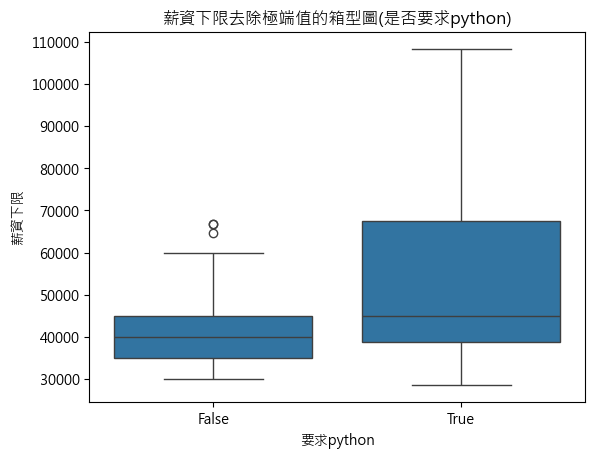

In [130]:
sns.boxplot(x='要求python',y="薪資下限",data=df_no_outlier)
plt.title("薪資下限去除極端值的箱型圖(是否要求python)")

### 因有明顯右偏態，故取自然對數，使資料分布更接近常態分佈。

In [131]:
df_no_outlier['log_薪資下限']=np.log(df_no_outlier['薪資下限'])

with_py_log=df_no_outlier[df_no_outlier['要求python']]['log_薪資下限']
without_py_log=df_no_outlier[~df_no_outlier['要求python']]['log_薪資下限']

### 檢查常態性(shapiro-wilk)

In [132]:
stats.shapiro(with_py_log)  #拒絕虛無假設(H0:符合常態性),故不建議使用一般T-test

ShapiroResult(statistic=np.float64(0.9136601797252251), pvalue=np.float64(2.1328516346297424e-05))

In [133]:
stats.shapiro(without_py_log)  #拒絕虛無假設(H0:符合常態性),故不建議使用一般T-test

ShapiroResult(statistic=np.float64(0.9273640961477022), pvalue=np.float64(0.00012349289407460854))

### 檢查變異數齊性(levene's test)

In [134]:
stats.levene(with_py_log,without_py_log)  #拒絕虛無假設(H0:變異數同質),故不建議使用一般T-test

LeveneResult(statistic=np.float64(23.12855020360593), pvalue=np.float64(3.292810623100801e-06))

### 因資料不符合 t-test 的前提（常態性與變異數齊性），故改用非參數檢定 Mann-Whitney U Test。該檢定不要求資料常態分布與變異數齊性，適用於比較兩組樣本的中位數是否存在顯著差異。

In [135]:
with_py_no_outlier=df_no_outlier[df_no_outlier['要求python']]['薪資下限']
without_py_no_outlier=df_no_outlier[~df_no_outlier['要求python']]['薪資下限']
u_stat,p_value=stats.mannwhitneyu(with_py_no_outlier,without_py_no_outlier,alternative="two-sided")
print(f"Mann-Whitneyu U test 統計量:{u_stat}")
print(f"p-value:{p_value}")    #0.00003911....< 0.05 ，拒絕H0(H0:要求python,不要求python 兩組中位數相等)，故兩者中位數具有顯著差異。

Mann-Whitneyu U test 統計量:5144.5
p-value:3.911293712563109e-05


In [ ]:
df_no_outlier['要求python'].value_counts()

要求python
True     88
False    86
Name: count, dtype: int64